# Mario vs Wario

## Libraries and UDFs ----

In [60]:
# Loading libraries ----

# misc
import os
import shutil
from random import sample, randint  
import math

# youtube
from pytube import YouTube

# image operation
import cv2
import matplotlib.pyplot as plt
from PIL import Image
# keras 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

# lime
import lime

In [43]:
# UDFs ----

def scrape_frames(video_name, dest_path, n_images, skip_seconds):
    vidcap = cv2.VideoCapture(video_name)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(vidcap.get(cv2.CAP_PROP_FPS))
    every_x_frame = math.floor((total_frames - skip_seconds * fps) / n_images) - 1

    success,image = vidcap.read()
    frame_count = 0
    img_count = 0
    
    while success: # check success here might break your program
        success,image = vidcap.read() #success might be false and image might be None
        
        if frame_count > (skip_seconds * 30):
            # break if the video ended
            if not success:
                break

            # action on every x-th frame 
            if (frame_count % every_x_frame == 0):
                cv2.imwrite(dest_path + "_" + str(img_count) + '.jpg', image)   
                img_count += 1
                if (round(img_count / n_images, 2) * 100 % 10 == 0): 
                    print("Completed:", round(img_count / n_images, 2), "done.", end="\r")

            if img_count == n_images:
                break   
            
        frame_count += 1
        
def move_random_files(path_from, path_to, n):
    files = os.listdir(path_from)
    files.sort()
    files = files[1:] #omiting .DS_Store

    for i in sample(range(0, len(files)-1), n):
        f = files[i]
        src = path_from + f
        dst = path_to + f
        shutil.move(src, dst)
        
def preview_random_image(path):
    files = os.listdir(path)
    img_name = files[randint(0, len(files) - 1)]
    img_preview_name = path + img_name
    image = Image.open(img_preview_name)
    plt.imshow(image)
    plt.title(img_name)
    plt.show()
    width, height = image.size
    print ("Dimensions:", image.size, "Total pixels:", width * height)

## Downloading videos ----

In [6]:
mario_video = YouTube('https://www.youtube.com/watch?v=lXMJt5PP3kM')

In [7]:
print('Title:', mario_video.title, '---')
stream = mario_video.streams.filter(file_extension = "mp4").all()
for i in stream:
    print(i)

Title: Game Boy Longplay [005] Super Mario Land 2: 6 Golden Coins ---
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2">
<Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d400b">
<Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400b">
<Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2">


In [8]:
mario_video.streams.get_by_itag(18).download()

In [9]:
wario_video = YouTube('https://www.youtube.com/watch?v=ZJuxdR0KH-s')

In [10]:
print('Title:', wario_video.title, '---')
stream = wario_video.streams.filter(file_extension = "mp4").all()
for i in stream:
    print(i)

Title: Game Boy Longplay [004] Super Mario Land 3: Wario Land ---
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2">
<Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d400d">
<Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400c">
<Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2">


In [11]:
wario_video.streams.get_by_itag(18).download()

## Cutting frames from the videos ----

In [14]:
# getting frames from Mario
scrape_frames('Game Boy Longplay [005] Super Mario Land 2 6 Golden Coins.mp4', 
              'training_set/mario/mario',
              every_x_frame = 30, 
              n_images = 5000,
              skip_seconds = 60)

In [3]:
# getting frames from Wario
scrape_frames('Game Boy Longplay [004] Super Mario Land 3 Wario Land.mp4', 
              'training_set/wario/wario',
              every_x_frame = 50, 
              n_images = 5000,
              skip_seconds = 60)

## Data preprocessing ----

### splitting data into training and test sets

In [13]:
move_random_files(path_from = 'training_set/mario/', 
                  path_to = 'test_set/mario/', 
                  n = 1000)

In [14]:
move_random_files(path_from = 'training_set/wario/', 
                  path_to = 'test_set/wario/', 
                  n = 1000)

### image preview

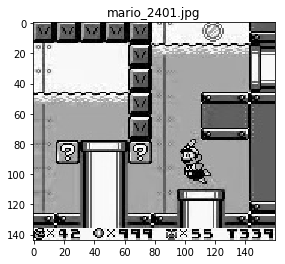

Dimensions: (160, 144) Total pixels: 23040


In [44]:
preview_random_image('training_set/mario/')

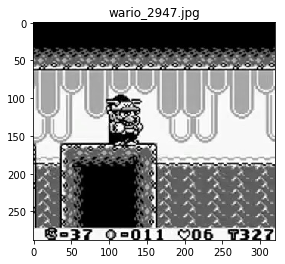

Dimensions: (320, 288) Total pixels: 92160


In [45]:
preview_random_image('training_set/wario/')

### preparing training and test sets

In [35]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Initialising CNN

In [48]:
# Initialising 
classifier = Sequential()

# Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

# Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding 2nd convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening
classifier.add(Flatten())

# Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total para

In [40]:
# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

## Fitting the model

In [42]:
classifier.fit_generator(training_set,
                         steps_per_epoch = 1000,
                         epochs = 5,
                         validation_data = test_set,
                         validation_steps = 2000)

Epoch 1/5
1000/1000 [==============================] - 221s 221ms/step - loss: 0.2785 - acc: 0.8721 - val_loss: 0.2112 - val_acc: 0.9148
Epoch 2/5
1000/1000 [==============================] - 215s 215ms/step - loss: 0.1035 - acc: 0.9608 - val_loss: 0.2823 - val_acc: 0.9029
Epoch 3/5
1000/1000 [==============================] - 219s 219ms/step - loss: 0.0723 - acc: 0.9727 - val_loss: 0.2533 - val_acc: 0.9033
Epoch 4/5
1000/1000 [==============================] - 220s 220ms/step - loss: 0.0573 - acc: 0.9786 - val_loss: 0.2238 - val_acc: 0.9341
Epoch 5/5
1000/1000 [==============================] - 226s 226ms/step - loss: 0.0468 - acc: 0.9832 - val_loss: 0.2565 - val_acc: 0.9230


In [49]:
# saving model and weights 
classifier.save_weights('mario_vs_wario_weights.h5')
classifier.save('mario_vs_wario_model.h5')